# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [3]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [4]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.70541304045e-09
next_c error:  5.81431230888e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [5]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.99641411515e-10
dh error:  4.73648988806e-10
dc error:  1.5221723979e-10
dWx error:  1.80515349645e-09
dWh error:  4.26458566943e-08
db error:  3.38039038057e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [6]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.61053744227e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-7` or less.

In [7]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  9.70556948185e-09
dh0 error:  1.91613016307e-08
dWx error:  2.44735455933e-09
dWh error:  2.71624177442e-06
db error:  2.13573163055e-09


# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [8]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443
expected loss:  9.82445935443
difference:  2.26130225656e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see losses less than 0.5.

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829098
(Iteration 21 / 100) loss: 30.062571
(Iteration 31 / 100) loss: 14.020202
(Iteration 41 / 100) loss: 6.006185
(Iteration 51 / 100) loss: 1.855580
(Iteration 61 / 100) loss: 0.648822
(Iteration 71 / 100) loss: 0.287449
(Iteration 81 / 100) loss: 0.244881
(Iteration 91 / 100) loss: 0.127282


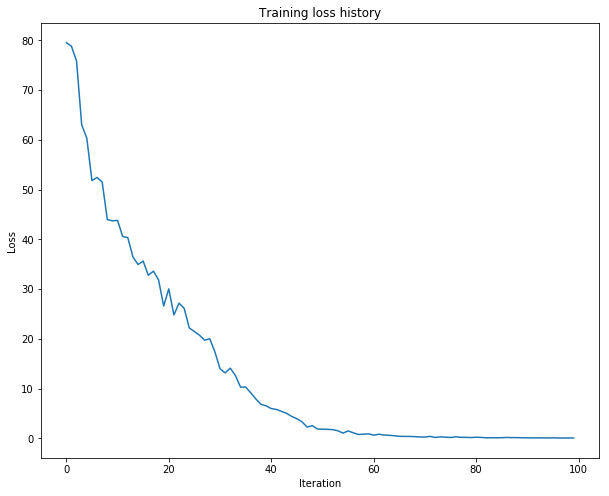

In [9]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

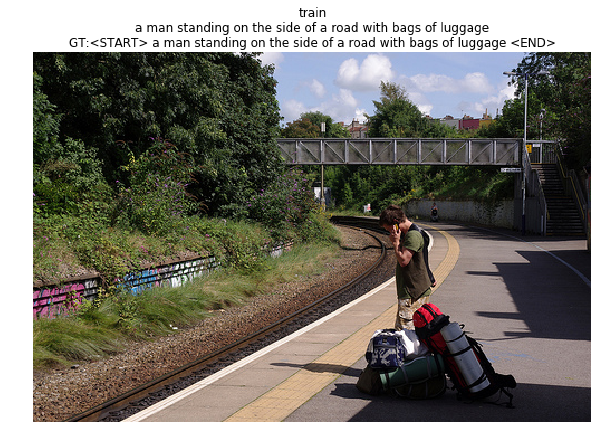

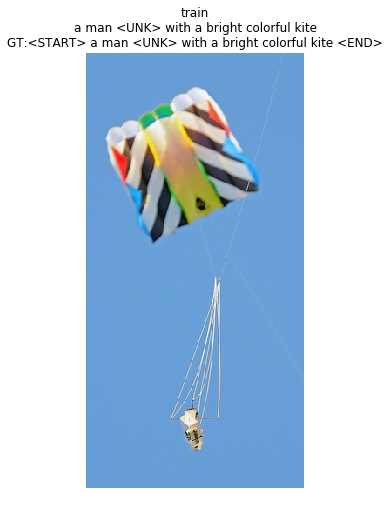

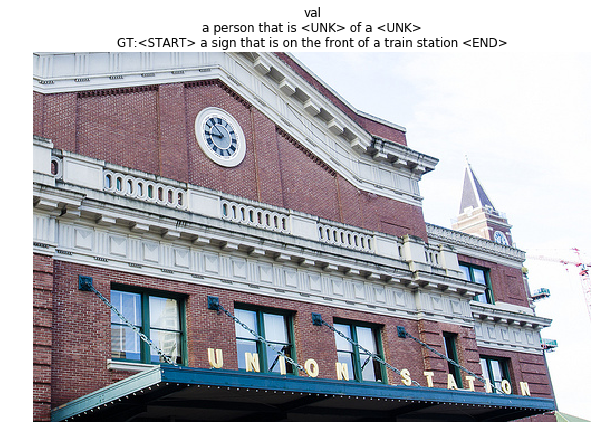

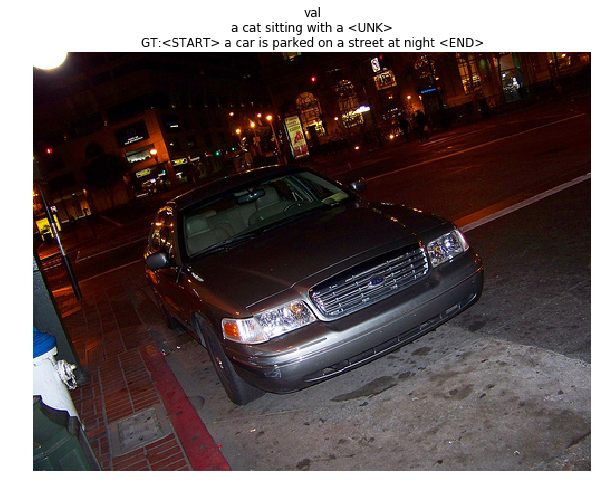

In [10]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Extra Credit: Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validation set that are better than random.

In addition to qualitatively evaluating your model by inspecting its results, you can also quantitatively evaluate your model using the BLEU unigram precision metric. We'll give you a small amount of extra credit if you can train a model that achieves a BLEU unigram score of >0.3. BLEU scores range from 0 to 1; the closer to 1, the better. Here's a reference to the [paper](http://www.aclweb.org/anthology/P02-1040.pdf) that introduces BLEU if you're interested in learning more about how it works.

Feel free to use PyTorch or TensorFlow for this section if you'd like to train faster on a GPU... though you can definitely get above 0.3 using your Numpy code. We're providing you the evaluation code that is compatible with the Numpy model as defined above... you should be able to adapt it for TensorFlow/PyTorch if you go that route.

In [11]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(med_data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [14]:
bleu_data = load_coco_data(max_train=2000)

bleu_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

bleu_lstm_solver = CaptioningSolver(bleu_lstm_model, bleu_data,
           update_rule='adam',
           num_epochs=200,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

bleu_lstm_solver.train()

(Iteration 1 / 16000) loss: 77.175791
(Iteration 11 / 16000) loss: 54.697292
(Iteration 21 / 16000) loss: 50.721325
(Iteration 31 / 16000) loss: 45.019049
(Iteration 41 / 16000) loss: 42.953707
(Iteration 51 / 16000) loss: 42.748327
(Iteration 61 / 16000) loss: 42.326929
(Iteration 71 / 16000) loss: 38.182691
(Iteration 81 / 16000) loss: 38.901287
(Iteration 91 / 16000) loss: 37.691453
(Iteration 101 / 16000) loss: 32.826913
(Iteration 111 / 16000) loss: 31.300934
(Iteration 121 / 16000) loss: 35.210283
(Iteration 131 / 16000) loss: 33.520188
(Iteration 141 / 16000) loss: 34.846253
(Iteration 151 / 16000) loss: 31.918830
(Iteration 161 / 16000) loss: 30.410555
(Iteration 171 / 16000) loss: 30.223722
(Iteration 181 / 16000) loss: 27.540286
(Iteration 191 / 16000) loss: 30.434749
(Iteration 201 / 16000) loss: 31.504350
(Iteration 211 / 16000) loss: 28.888989
(Iteration 221 / 16000) loss: 28.421999
(Iteration 231 / 16000) loss: 26.775043
(Iteration 241 / 16000) loss: 21.294630
(Iteration 

(Iteration 2061 / 16000) loss: 3.938844
(Iteration 2071 / 16000) loss: 4.079718
(Iteration 2081 / 16000) loss: 5.237406
(Iteration 2091 / 16000) loss: 2.536726
(Iteration 2101 / 16000) loss: 3.504880
(Iteration 2111 / 16000) loss: 4.672456
(Iteration 2121 / 16000) loss: 3.369663
(Iteration 2131 / 16000) loss: 3.307559
(Iteration 2141 / 16000) loss: 4.635996
(Iteration 2151 / 16000) loss: 5.458074
(Iteration 2161 / 16000) loss: 4.698787
(Iteration 2171 / 16000) loss: 3.936496
(Iteration 2181 / 16000) loss: 3.365311
(Iteration 2191 / 16000) loss: 3.665309
(Iteration 2201 / 16000) loss: 3.691985
(Iteration 2211 / 16000) loss: 3.659665
(Iteration 2221 / 16000) loss: 3.691174
(Iteration 2231 / 16000) loss: 3.604828
(Iteration 2241 / 16000) loss: 4.272405
(Iteration 2251 / 16000) loss: 4.282517
(Iteration 2261 / 16000) loss: 3.869490
(Iteration 2271 / 16000) loss: 3.788138
(Iteration 2281 / 16000) loss: 4.414349
(Iteration 2291 / 16000) loss: 4.353397
(Iteration 2301 / 16000) loss: 3.883785


(Iteration 4111 / 16000) loss: 2.982188
(Iteration 4121 / 16000) loss: 1.708593
(Iteration 4131 / 16000) loss: 2.444980
(Iteration 4141 / 16000) loss: 2.624829
(Iteration 4151 / 16000) loss: 2.897537
(Iteration 4161 / 16000) loss: 2.083598
(Iteration 4171 / 16000) loss: 2.957427
(Iteration 4181 / 16000) loss: 2.200363
(Iteration 4191 / 16000) loss: 2.963980
(Iteration 4201 / 16000) loss: 3.931037
(Iteration 4211 / 16000) loss: 2.017498
(Iteration 4221 / 16000) loss: 2.796858
(Iteration 4231 / 16000) loss: 2.123603
(Iteration 4241 / 16000) loss: 2.610470
(Iteration 4251 / 16000) loss: 2.031366
(Iteration 4261 / 16000) loss: 2.181756
(Iteration 4271 / 16000) loss: 2.096063
(Iteration 4281 / 16000) loss: 2.479668
(Iteration 4291 / 16000) loss: 2.612858
(Iteration 4301 / 16000) loss: 2.164909
(Iteration 4311 / 16000) loss: 1.844727
(Iteration 4321 / 16000) loss: 2.283942
(Iteration 4331 / 16000) loss: 1.824474
(Iteration 4341 / 16000) loss: 2.459784
(Iteration 4351 / 16000) loss: 2.279991


(Iteration 6161 / 16000) loss: 1.349532
(Iteration 6171 / 16000) loss: 1.622226
(Iteration 6181 / 16000) loss: 1.462948
(Iteration 6191 / 16000) loss: 0.662843
(Iteration 6201 / 16000) loss: 1.506125
(Iteration 6211 / 16000) loss: 1.177828
(Iteration 6221 / 16000) loss: 1.551654
(Iteration 6231 / 16000) loss: 1.518900
(Iteration 6241 / 16000) loss: 1.130451
(Iteration 6251 / 16000) loss: 1.607307
(Iteration 6261 / 16000) loss: 0.860325
(Iteration 6271 / 16000) loss: 1.796478
(Iteration 6281 / 16000) loss: 1.149137
(Iteration 6291 / 16000) loss: 1.795936
(Iteration 6301 / 16000) loss: 1.361009
(Iteration 6311 / 16000) loss: 2.041636
(Iteration 6321 / 16000) loss: 2.150806
(Iteration 6331 / 16000) loss: 1.529936
(Iteration 6341 / 16000) loss: 1.257078
(Iteration 6351 / 16000) loss: 1.540788
(Iteration 6361 / 16000) loss: 1.963233
(Iteration 6371 / 16000) loss: 1.666858
(Iteration 6381 / 16000) loss: 1.700683
(Iteration 6391 / 16000) loss: 2.711425
(Iteration 6401 / 16000) loss: 1.116630


(Iteration 8211 / 16000) loss: 0.666891
(Iteration 8221 / 16000) loss: 1.464599
(Iteration 8231 / 16000) loss: 1.189434
(Iteration 8241 / 16000) loss: 0.710697
(Iteration 8251 / 16000) loss: 1.035656
(Iteration 8261 / 16000) loss: 1.160316
(Iteration 8271 / 16000) loss: 0.732043
(Iteration 8281 / 16000) loss: 1.124238
(Iteration 8291 / 16000) loss: 1.053006
(Iteration 8301 / 16000) loss: 0.854500
(Iteration 8311 / 16000) loss: 1.189803
(Iteration 8321 / 16000) loss: 0.681570
(Iteration 8331 / 16000) loss: 1.003276
(Iteration 8341 / 16000) loss: 0.876210
(Iteration 8351 / 16000) loss: 1.372031
(Iteration 8361 / 16000) loss: 1.243826
(Iteration 8371 / 16000) loss: 1.491225
(Iteration 8381 / 16000) loss: 1.403779
(Iteration 8391 / 16000) loss: 1.169022
(Iteration 8401 / 16000) loss: 1.138418
(Iteration 8411 / 16000) loss: 0.883667
(Iteration 8421 / 16000) loss: 1.546457
(Iteration 8431 / 16000) loss: 0.885990
(Iteration 8441 / 16000) loss: 0.558302
(Iteration 8451 / 16000) loss: 0.999465


(Iteration 10261 / 16000) loss: 0.558152
(Iteration 10271 / 16000) loss: 0.584277
(Iteration 10281 / 16000) loss: 0.376643
(Iteration 10291 / 16000) loss: 0.865035
(Iteration 10301 / 16000) loss: 1.045630
(Iteration 10311 / 16000) loss: 0.940411
(Iteration 10321 / 16000) loss: 0.661215
(Iteration 10331 / 16000) loss: 0.860573
(Iteration 10341 / 16000) loss: 0.621492
(Iteration 10351 / 16000) loss: 1.459432
(Iteration 10361 / 16000) loss: 0.938320
(Iteration 10371 / 16000) loss: 1.201868
(Iteration 10381 / 16000) loss: 0.610833
(Iteration 10391 / 16000) loss: 1.270829
(Iteration 10401 / 16000) loss: 0.700843
(Iteration 10411 / 16000) loss: 0.640854
(Iteration 10421 / 16000) loss: 0.593538
(Iteration 10431 / 16000) loss: 1.082511
(Iteration 10441 / 16000) loss: 0.768561
(Iteration 10451 / 16000) loss: 0.893359
(Iteration 10461 / 16000) loss: 0.829689
(Iteration 10471 / 16000) loss: 0.580337
(Iteration 10481 / 16000) loss: 0.702216
(Iteration 10491 / 16000) loss: 0.716123
(Iteration 10501

(Iteration 12261 / 16000) loss: 0.621416
(Iteration 12271 / 16000) loss: 0.543892
(Iteration 12281 / 16000) loss: 0.462535
(Iteration 12291 / 16000) loss: 0.672289
(Iteration 12301 / 16000) loss: 0.744568
(Iteration 12311 / 16000) loss: 0.615348
(Iteration 12321 / 16000) loss: 0.579158
(Iteration 12331 / 16000) loss: 0.521713
(Iteration 12341 / 16000) loss: 0.493693
(Iteration 12351 / 16000) loss: 0.688241
(Iteration 12361 / 16000) loss: 0.750233
(Iteration 12371 / 16000) loss: 0.711934
(Iteration 12381 / 16000) loss: 0.719779
(Iteration 12391 / 16000) loss: 0.843164
(Iteration 12401 / 16000) loss: 0.595892
(Iteration 12411 / 16000) loss: 0.548079
(Iteration 12421 / 16000) loss: 0.599055
(Iteration 12431 / 16000) loss: 0.740288
(Iteration 12441 / 16000) loss: 0.398547
(Iteration 12451 / 16000) loss: 0.686470
(Iteration 12461 / 16000) loss: 0.673554
(Iteration 12471 / 16000) loss: 0.480572
(Iteration 12481 / 16000) loss: 0.752965
(Iteration 12491 / 16000) loss: 0.551148
(Iteration 12501

(Iteration 14261 / 16000) loss: 0.184632
(Iteration 14271 / 16000) loss: 0.154502
(Iteration 14281 / 16000) loss: 0.073269
(Iteration 14291 / 16000) loss: 0.092031
(Iteration 14301 / 16000) loss: 0.061099
(Iteration 14311 / 16000) loss: 0.092535
(Iteration 14321 / 16000) loss: 0.086856
(Iteration 14331 / 16000) loss: 0.125123
(Iteration 14341 / 16000) loss: 0.068311
(Iteration 14351 / 16000) loss: 0.145650
(Iteration 14361 / 16000) loss: 0.040326
(Iteration 14371 / 16000) loss: 0.127880
(Iteration 14381 / 16000) loss: 0.078311
(Iteration 14391 / 16000) loss: 0.069627
(Iteration 14401 / 16000) loss: 0.056079
(Iteration 14411 / 16000) loss: 0.063952
(Iteration 14421 / 16000) loss: 0.072793
(Iteration 14431 / 16000) loss: 0.041907
(Iteration 14441 / 16000) loss: 0.364342
(Iteration 14451 / 16000) loss: 0.041218
(Iteration 14461 / 16000) loss: 0.056134
(Iteration 14471 / 16000) loss: 0.113286
(Iteration 14481 / 16000) loss: 0.086574
(Iteration 14491 / 16000) loss: 0.067193
(Iteration 14501

In [15]:
import nltk
med_data = bleu_data # load_coco_data()
BLEUscores = {}
evaluate_model(bleu_lstm_model)

Average BLEU score for train: 0.995902
Average BLEU score for val: 0.203546
